In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm_notebook
import pickle

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
# Dataset import

df = pd.read_csv("Py_Dataset.csv")
df.head()

,Unnamed: 0,Date,Y_log,Rural,Time,NS,quota,Provincia,Zonizzazione,Tipo,id
0,1,2018-01-01,3.688645,1,0,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
1,2,2018-01-02,2.743930,1,1,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
2,3,2018-01-03,2.687557,1,2,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
3,4,2018-01-04,2.850192,1,3,BADIA,0.522332,PR,Pianura Ovest,Fondo,1
4,5,2018-01-05,3.558992,1,4,BADIA,0.522332,PR,Pianura Ovest,Fondo,1


In [3]:
staz = pd.read_csv("Stazioni_Emilia.csv")
staz.head()

,NomeStazione,Lat,Long,Regione,Quota,Provincia,AreaStazione,TipoStazione,id
0,BADIA,44.658309,10.285714,Emilia-Romagna,202.0,PR,Rurale,Fondo,1
1,BESENZONE,44.987113,9.955758,Emilia-Romagna,50.0,PC,Rurale,Fondo,2
2,BOGOLESE,44.835555,10.397238,Emilia-Romagna,35.0,PR,Suburbano,Industriale,3
3,CAORLE,44.418868,12.224176,Emilia-Romagna,4.0,RA,Urbano,Fondo,4
4,CASTELLARANO,44.532199,10.706261,Emilia-Romagna,150.0,RE,Suburbano,Fondo,5


2.3056598969634683

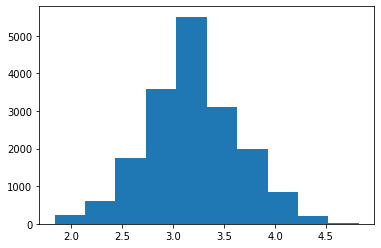

In [4]:
plt.hist(df.Y_log)
np.std(df.Y_log)*5 # a = 3, b = 2 per invgamma

In [5]:
# dummies

dummies = pd.get_dummies(df.Tipo)
dummies.head()

,Fondo,Industriale,Traffico
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


# MODEL INPUT

- N = length(Y) = number of total samples 
- k = number of Fourier basis (2/4/8/12)
- p = 3 = number of regressors {quota + tipo(dummyx2)}


- y {N vector} : PM10 time series
- x {Nxp matrix} : covariates matrix
- t {N vector} : time istant
- r {N vector binary} : 1 if rural, 0 otherwise
- omega = 2$\pi$/365 : annual frequency


# MODEL PARAMETERS

- a {k/2 vector} : sin coefficients
- b {k/2 vector} : cos coefficients
- c {real} : constant term for f(t)


- a_r {k/2 vector} : sin coefficients - rural 
- b_r {k/2 vector} : cos coefficients - rural
- c_r {real} : constant term for fr(t) - rural


- beta {p vector} : covariates coefficients
- sigma_sq {real > 0} : y variance


In [26]:
normal_reg_prior = """
data {
    int<lower=0> N; 
    int<lower=0> k;
    int<lower=0> p;
    int<lower=0> G;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    int stazione[N];
    real omega;
    row_vector[2] coord[G];
}

transformed data {
    int K;
    K = k%/%2;
}

parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[K] a;
    vector[K] b;
    real c;
    
    vector[K] a_r;
    vector[K] b_r;
    real c_r;
    
    vector[G] w;
    real<lower=0> rho;
    real<lower=0> alpha;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(c, N));
    for (j in 1:K){
     ft += a[j]*sin(j*omega*t) + b[j]*cos(j*omega*t);
    }
    
    vector[N] ft_r;
    ft_r = to_vector(rep_array(c_r, N));
    for (j in 1:K){
     ft_r += a_r[j]*sin(j*omega*t) + b_r[j]*cos(j*omega*t);
     }
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) 
         + X*beta ;
    mu[1:N] += w[stazione[1:N]];
         
    cov_matrix[G] H = cov_exp_quad(coord, alpha, rho);
}

model {  

    sigma_sq ~ inv_gamma(3, 2);
    
    beta ~ normal(0, 1);
    
    a ~ normal([-0.01, -0.01, 0.01, 0.06, -0.04, -0.02], 1);
    b ~ normal([0.3, 0.02, 0.03, 0.03, 0.03, -0.03], 1);
    c ~ normal(3.4, 2);
    
    a_r ~ normal([-0.05, -0.03, 0.02, 0.04, -0.05, -0.04], 1);
    b_r ~ normal([0.06, -0.02, 0.02, 0.01, 0.03, -0.03], 1);
    c_r ~ normal(3.1, 2);
    
    rho ~ beta(2, 200);

    w ~ multi_normal(rep_vector(0,G),H);
    
    Y ~ normal(mu, sigma);  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
}
"""

stan_file = "./normal_reg_prior.stan"

with open(stan_file, "w") as f:
    print(normal_reg_prior, file=f)

normal_reg_prior = CmdStanModel(stan_file=stan_file)

stanc3 has produced warnings:
Warning in '/Users/michelafrigeri/JupyterProjects/PROGETTO/normal_reg_prior.stan', line 63, column 22: cov_exp_quad is deprecated and will be removed in the future. Use gp_exp_quad_cov instead.


In [27]:
y = np.array(df.Y_log)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
stazione = np.array(df.id)
omega = 2*np.pi/365
coord = np.matrix( pd.concat([staz.Lat, staz.Long], axis=1) )

N = len(y)
p = 3   # Quota + Tipo(2 dummies)
k = 12   # 4 basi di fourier + const
G = 49  # numero stazioni in Emilia-Romagna

In [ ]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "k": k,   # Fbasis number
    "p": p,   # 3
    "G": G,
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,
    "stazione": stazione,
    "omega": omega,
    "coord": coord
}

fit = normal_reg_prior.sample(data=reg_data, chains=3, parallel_chains=3, 
                             iter_warmup=1000, iter_sampling=2000, show_progress=True)


Chain 2 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   3%|▋                   | 100/3000 [03:13<1:33:41,  1.94s/it]

Chain 1 - warmup:   7%|█▎                  | 200/3000 [05:09<1:14:36,  1.60s/it]

Chain 2 - warmup:   7%|█▎                  | 200/3000 [07:23<1:45:44,  2.27s/it]

Chain 2 - warmup:  10%|██                  | 300/3000 [10:01<1:27:48,  1.95s/it]

Chain 1 - warmup:  13%|██▋                 | 400/3000 [13:34<1:36:58,  2.24s/it]

Chain 1 - warmup:  17%|███▎                | 500/3000 [17:06<1:31:25,  2.19s/it]

Chain 1 - warmup:  20%|████                | 600/3000 [20:15<1:23:39,  2.09s/it]

Chain 2 - warmup:  23%|████▋               | 700/3000 [20:52<1:04:10,  1.67s/it]

Chain 2 - warmup:  30%|██████▌               | 900/3000 [25:13<51:13,  1.46s/it]

Chain 2 - sample

In [14]:
import pickle

# salva la catena con pickle
pickle.dump(fit, open( "save1.p", "wb" ))

#apro la catena con pickle
prova = pickle.load( open( "wi_4chain_largeparam_6b.p", "rb" ) )

#non credo serva a niente (o almeno a noi non serve) il comando .draws_pd 
#pd = prova.draws_pd()
print(prova)

In [9]:
# cerchiamo w_i verde : che stazione è ???
w_chain = fit.stan_variable(var='w')
type(w_chain)
w_chain.shape
plt.plot(range(16000), w_chain[:,0])
plt.show()
sns.kdeplot(w_chain[:,0])

NameError: name 'fit' is not defined

In [15]:
normal_az = az.from_cmdstanpy(fit)

Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "metadata.stan_vars_cols" instead.
Property "stan_vars_cols" has been deprecated, use "me

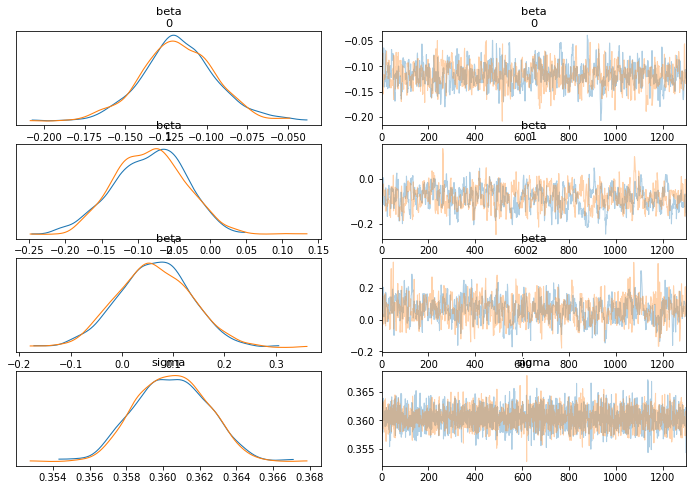

In [16]:
# parameters: beta and sigma
az.plot_trace(normal_az, var_names=["beta", "sigma"], compact=False)
plt.show()

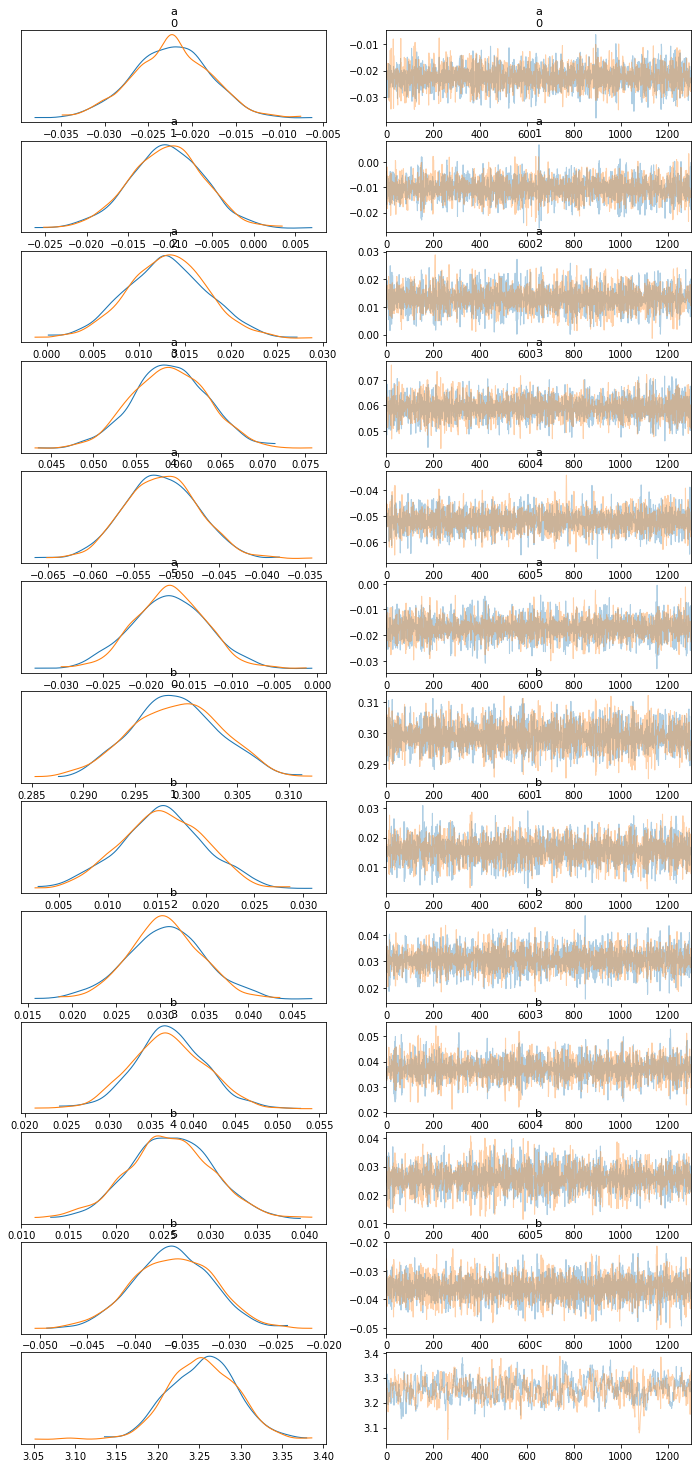

In [17]:
# parameters NON-rural f(t)
az.plot_trace(normal_az, var_names=["a", "b", "c"], compact=False)
plt.show()

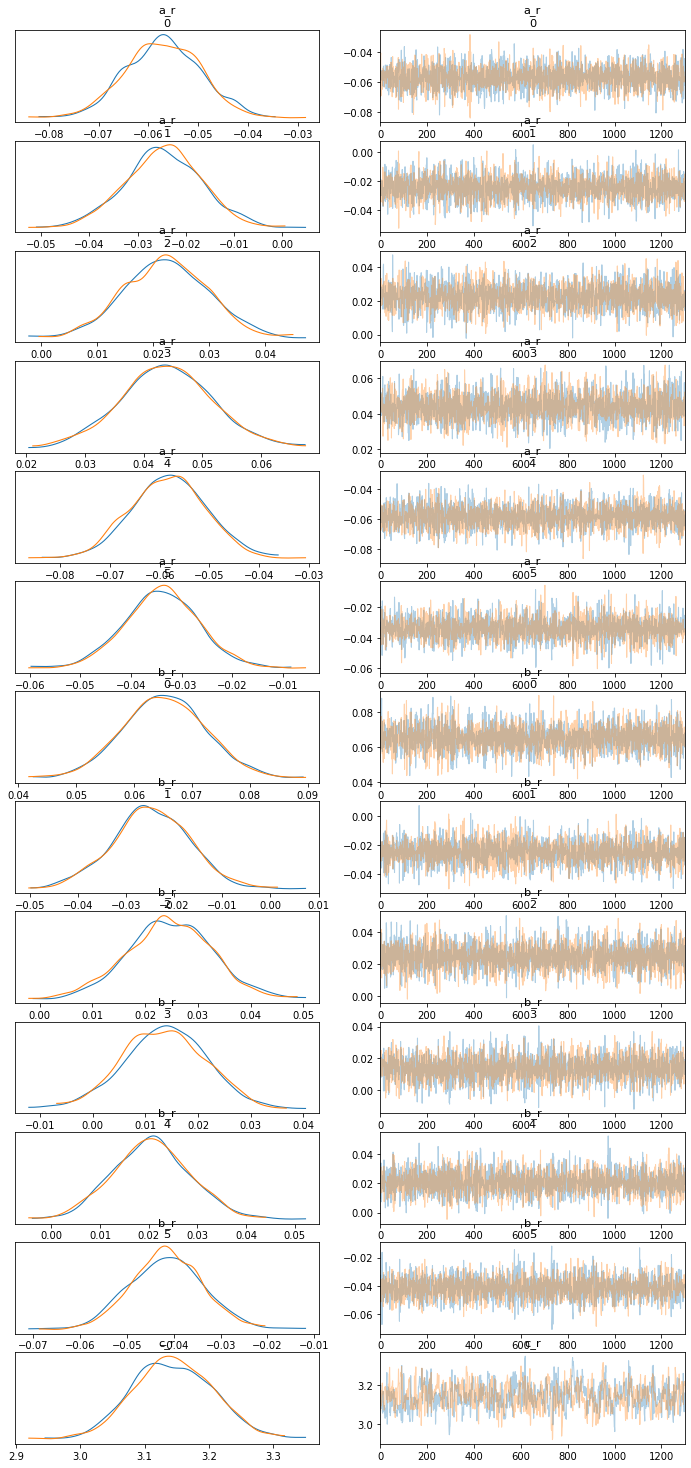

In [39]:
# parameters rural f(t)
az.plot_trace(normal_az, var_names=["a_r", "b_r", "c_r"], compact=False)
plt.show()

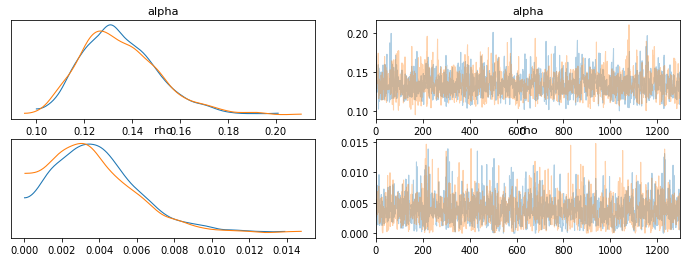

In [18]:
# parameters : alpha & rho
az.plot_trace(normal_az, var_names=["alpha", "rho"], compact=False)
plt.show()
# empirical variogram + fitting -> stime puntuali per rho e alpha -> centering for normal prior 

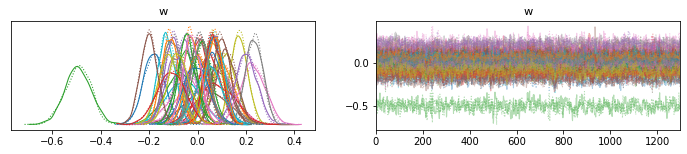

In [11]:
# parameters : wi
az.plot_trace(normal_az, var_names=["w"], compact=True)
plt.show()

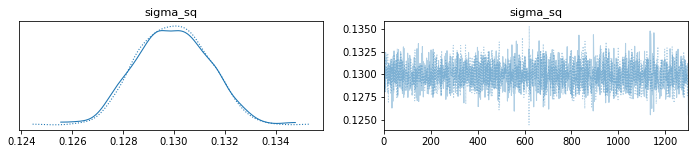

In [12]:
# transformed parameters: sigma^2
az.plot_trace(normal_az, var_names=["sigma_sq"])
plt.show()

In [17]:
# iterazioni divergenti? Nessuna
np.sum(normal_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [18]:
# GOF analysis
print("WAIC: ", az.waic(normal_az, var_name="log_lik"))

WAIC:  Computed from 16000 by 17836 log-likelihood matrix

          Estimate       SE
elpd_waic -7135.16   111.98
p_waic       74.68        -


In [ ]:
print("LOO: ", az.loo(normal_az, var_name="log_lik"))

In [ ]:
normal_az_2 = az.from_cmdstanpy(fit)

<AxesSubplot:ylabel='Density'>

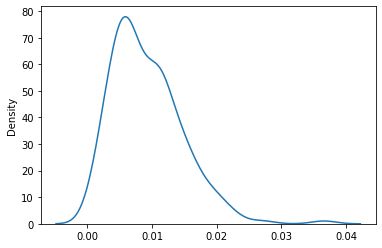

In [25]:
# Trials for rho ~ beta(a,b) parameters 
prova = np.random.beta(2, 200, 200)
sns.kdeplot(prova)

In [ ]:
# prova boxplot

beta_chain = fit_clust.stan_variable(var='beta')
type(beta_chain)
beta_chain.shape
plt.plot(range(4600), beta_chain[:,0])
plt.show()
sns.kdeplot(beta_chain[:,0])

In [ ]:
Q1 = np.quantile(beta_chain[0,:], 0.25)
Q2 = np.quantile(beta_chain[0,:], 0.5)
Q3 = np.quantile(beta_chain[0,:], 0.75)
print(Q1,Q2,Q3)